In [126]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
import numpy as np

I've tried out (what I think is) Shudian's problem formulation. It seems to work pretty well.

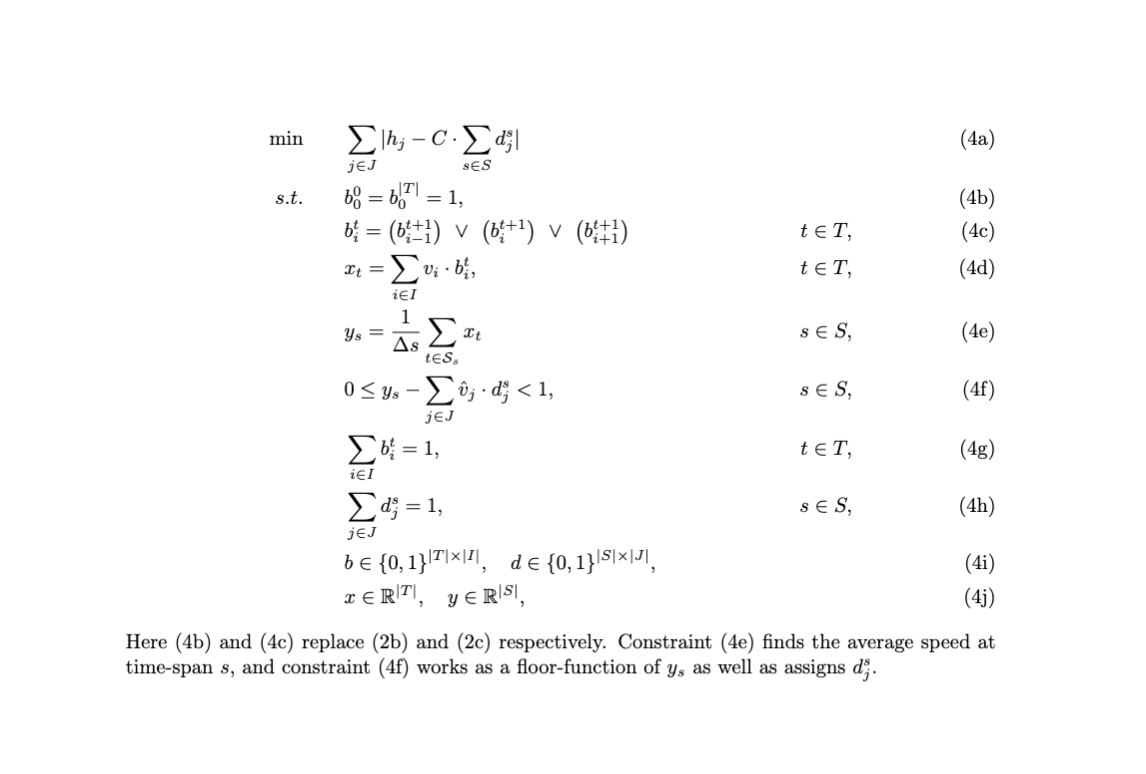

In [128]:
from IPython.display import Image
display(Image(filename='shudians_formulation.png'))

In [129]:
#Data “Stadtradeln 2020”
#The unit of X is [km/h], the unit of Y is [s]
V_20 = [x for x in range(0,50)]
H_20 = [5024.0, 15109.0, 25407.0, 37754.0, 63220.0, 106746.0, 195828.0, 339145.0, 587985.0, 977218.0, 1521230.0, 2254539.0, 3161007.0, 4220219.0, 5382534.0, 6637724.0, 7802254.0, 8708635.0, 9094110.0, 8834248.0, 7846950.0, 6338575.0, 4651152.0, 3127454.0, 2041953.0, 1358565.0, 930478.0, 638112.0, 448834.0, 315900.0, 232795.0, 168504.0, 124620.0, 92653.0, 71160.0, 54409.0, 42382.0, 32513.0, 26013.0, 20612.0, 15783.0, 12515.0, 9633.0, 7781.0, 6232.0, 4767.0, 3944.0, 3197.0, 2493.0, 1010.0]
 
#Data “Stadtradeln 2019”
#The unit of X is [km/h], the unit of Y is [s]
V_19 = [x for x in range(0,50)]
H_19 = [5217.0, 7144.0, 10296.0, 16075.0, 27757.0, 43795.0, 74943.0, 127157.0, 202481.0, 324309.0, 514241.0, 772987.0, 1117721.0, 1518676.0, 2005031.0, 2499377.0, 2942067.0, 3284328.0, 3345193.0, 3173818.0, 2784324.0, 2243990.0, 1632086.0, 1054617.0, 648473.0, 397431.0, 248240.0, 168406.0, 116072.0, 79887.0, 56224.0, 40702.0, 27863.0, 21272.0, 15171.0, 10974.0, 8207.0, 6228.0, 4466.0, 3664.0, 2979.0, 2205.0, 2139.0, 1293.0, 929.0, 945.0, 1025.0, 570.0, 363.0, 141.0]
 

#Data “Stadtradeln 2018”
#The unit of X is [km/h], the unit of Y is [s]
V_18 = [x for x in range(0,50)]
H_18 = [518.0, 1229.0, 2478.0, 4601.0, 8898.0, 13753.0, 21473.0, 35593.0, 57540.0, 86025.0, 129153.0, 195069.0, 281591.0, 382835.0, 501775.0, 628368.0, 735269.0, 810814.0, 823104.0, 803804.0, 732389.0, 629978.0, 484177.0, 335954.0, 207336.0, 125265.0, 74005.0, 47482.0, 32548.0, 22063.0, 15102.0, 9152.0, 7149.0, 5149.0, 3501.0, 2849.0, 2031.0, 1880.0, 1524.0, 1326.0, 1157.0, 1024.0, 1010.0, 752.0, 861.0, 574.0, 772.0, 580.0, 366.0, 244.0]


In [132]:
H = H_20  # choose histogram to use
V_h = V_20  # supply the corresponding velocities to H

cycle_length = 25  # [min]; length of cycle
dt = 3  # [s]; time step; divisible by 60; (dt | 60)
ds = 5  # this means that the timespan we average over is dt_span*dt
# needs to be divisible as such: (dt_span*dt | 60)


a_0 = 0.6  # [km/h/s]; acceleration per second
a = a_0 * dt  # [km/h/timestep]; acceleration per timestep
T = int(cycle_length * 60 / dt)  # total number of time steps
S = int(T / ds)  # total number of timespans that we average over

v_max = V_h[-1]  # [km/h] this can be choosen freely (probably something slightly higher than 50km/h)

V_p = [] #create V_p, this is where we would have to add some pre-processing ...
         #... if we want the acceleration to be a function of speed
v = 0
while v < v_max:
    V_p.append(v)
    v = v + a

    
C = round(sum(H) / S)  # scale C so that number of *actual* observations (|H|)..
# ..roughly coincides with total observations in model (S = |T|/ds)


T_idx = [t for t in range(T)]  # create a vector with all timesteps t
S_idx = [s for s in range(S)]  # create a vector with all timespans s


S_s_idx = []  # span_idx[s] will give the corresponding time indices that s will average over
# i.e. "t \in s" will in code become "t in S_s_idx[s]"
for s in S_idx:
    span = []
    for t in range(ds):
        span.append(s * ds + t)
    S_s_idx.append(span)

Vp_idx = [i for i in range(len(V_p))]  # create a vector of idx for possible velocities
I = len(Vp_idx) - 1

Vh_idx = [j for j in range(len(V_h))]  # create a vector of idx for histogram velocities
# right now it is assumed *all* integers uptil v_max
J = len(Vh_idx) - 1


# look into how this would work here, right now not implemented;
# construct tuplets (time, velocity_index) but only if b(t,i) *can* be true:
# (this corresponds to our definition of V')
# currently implemented for (b)
# Does not alter solution, simply decreases computation (# of binary variables)


# tv_pair = [(t,i) for t in T_idx for i in Vp_idx           ... if vel[i] <= v_0 + a*min(T-t, t)]
ti_pair = [(t, i) for t in T_idx for i in Vp_idx]
# sj_pair = [(s,j) for s in S_idx for i in Vh_idx           ... if vel[i] <= v_0 + a*min(T-t, t)]
sj_pair = [(s, j) for s in S_idx for j in Vh_idx]


# construct velocity coefficients dictionary
# this is so that we can utilize gurobi function "prod" for easy implementation of constraint (e) later on
coeff_ti = {}
for k in range(len(ti_pair)):
    coeff_ti.update({ti_pair[k]: V_p[ti_pair[k][1]]})  # here we assign the velocity "v" to all tuples
    # tv_pair[k] = (t,i) so tv_pair[k][1] = i, (tv_pair[k][0] = t)
    # i.e., create "triplet" {(t,i):V_p[i]};
    # actually we create a dictionary where the unique key (t,i) maps
    # to the value V_p[i]
    
coeff_sj = {} #same for (s,j)-tup
for k in range(len(sj_pair)):
    coeff_sj.update({sj_pair[k]: V_h[sj_pair[k][1]]})  

# model
try:
    m = gp.Model("DF")

    b = m.addVars(ti_pair, vtype=GRB.BINARY,
                  name="b")  # b(t,i) binary variables (if = 1; choose velocity "V_p[i]" at time "t")
    d = m.addVars(sj_pair, vtype=GRB.BINARY,
                  name="d")  # d(s,j) binary variables (if = 1; choose average velocity "V_h[j]" during timespan "s")

    x = m.addVars(T_idx, name="x")  # vel kept at time t
    y = m.addVars(S_idx, name="y")  # average velocity at timespan s

    # diff, u and obj together corresponds to (a) - the objective function:
    diff = m.addVars(Vh_idx, lb=-C * S, name="diff")  # diff(j) = h(j) - C*sum(s, d(s,j)) - see constraint "defDiff"
    u = m.addVars(Vh_idx, name="u")  # u(j) = abs(diff(j)) - see constraint "absDiff"
    obj = sum(u[j] for j in Vh_idx)  # objective = sum(j, u(j))

    m.setObjective(obj, GRB.MINIMIZE)

    # constraints that help define the variables u(v) in the objective function:
    m.addConstrs((diff[j] == H[j] - C * d.sum("*", j) for j in Vh_idx), "defDiff")
    m.addConstrs((u[j] == gp.abs_(diff[j]) for j in Vh_idx), "absDiff")

    # constraint (b);

    m.addConstr((b[0, 0] == 1), "start")  # initial speed = V_p[0]
    m.addConstr((b[T - 1, 0] == 1), "end")  # final speed = V_p[0]

    # constraint (c);
    m.addConstrs((x[t] - a <= x[t + 1] for t in T_idx[0:-1]), "accelerate")  # increase by max a/timestep
    m.addConstrs((x[t + 1] <= x[t] + a for t in T_idx[0:-1]), "decelerate")  # decrease by max a/timestep

    #below is my attempt at the new constraint, not yet successfull
    # m.addConstrs(
    #    (b[t, i] == gp.or_(b[t + 1, i - 1], b[t + 1, i], b[t + 1, i + 1]) for t in T_idx[0:-1] for i in Vp_idx[1:-1]),
    #    "acceldeaccel")
    # m.addConstrs((b[t, 0] == gp.or_(b[t + 1, 0], b[t + 1, 1]) for t in T_idx[0:-1]), "ad0")
    # m.addConstrs((b[t, I] == gp.or_(b[t + 1, I], b[t + 1, I - 1]) for t in T_idx[0:-1]), "adI")

    
    #constraint (d);
    m.addConstrs((b.prod(coeff_ti, t, "*") == x[t] for t in T_idx), "assignSpeed")  # set speed x for time t
    
    
    #constraint (e);
    for s in S_idx:
        # m.addConstr((y[s] == sum(x[t] for t in span_idx[s])), "assignAvSpeed")
        m.addConstr((y[s] == gp.quicksum(x[t] for t in S_s_idx[s]) / ds), "assignAvSpeed")

        
    #constraint (f);
    m.addConstrs((y[s] - d.prod(coeff_sj, s, "*") <= 0.999999 for s in S_idx),
                 "assignSpeed")  # set bin_var d(s,j) for timespan s
    m.addConstrs((y[s] - d.prod(coeff_sj, s, "*") >= 0 for s in S_idx),
                 "assignSpeed2")  # set bin_var d(s,j) for timespan s

    
    # constraint (g)
    m.addConstrs((b.sum(t, "*") == 1 for t in T_idx), "bBinary")  # keep tack of binary variables b

    # constraint (h);
    m.addConstrs((d.sum(s, "*") == 1 for s in S_idx), "dBinary")  # keep tack of binary variables d

    m.optimize()
    # for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2450 rows, 19700 columns and 50648 nonzeros
Model fingerprint: 0x7b49eb7e
Model has 50 general constraints
Variable types: 700 continuous, 19000 integer (19000 binary)
Coefficient statistics:
  Matrix range     [2e-01, 9e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+07]
  RHS range        [1e+00, 9e+06]
Presolve added 81 rows and 0 columns
Presolve removed 0 rows and 1634 columns
Presolve time: 0.40s
Presolved: 2531 rows, 18066 columns, 47319 nonzeros
Variable types: 0 continuous, 18066 integer (17372 binary)
Found heuristic solution: objective 1.771918e+08

Root relaxation: objective 4.065219e+06, 2626 iterations, 0.23 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

  Gomory: 34
  Cover: 248
  Implied bound: 59
  Projected implied bound: 49
  Clique: 187
  MIR: 151
  StrongCG: 49
  Flow cover: 181
  GUB cover: 921
  Zero half: 78
  Relax-and-lift: 559

Explored 1692 nodes (900930 simplex iterations) in 273.14 seconds (95.23 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 8.78326e+06 8.78952e+06 9.54595e+06 ... 1.61382e+07

Optimal solution found (tolerance 1.00e-04)
Best objective 8.783259000000e+06, best bound 8.783259000000e+06, gap 0.0000%
Obj: 8.78326e+06


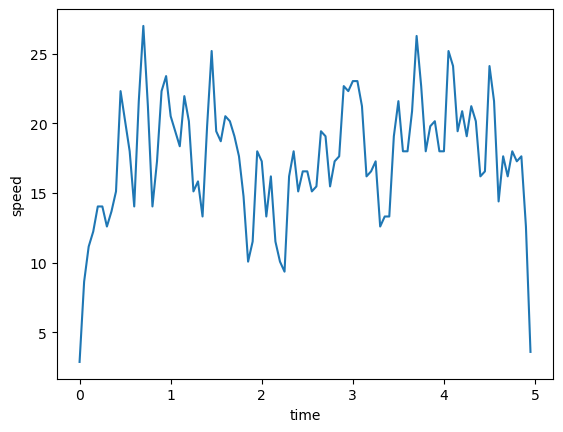

In [125]:
x_min = [x*dt/60 for x in range(0,len(time_spans))]

lr = m.getAttr("X", y)
#plt.plot(list(lr.keys()),list(lr.values()))
plt.plot(x_min,list(lr.values()))
plt.xlabel("time")
plt.ylabel("speed")
#plt.xticks(np.arange(0, 25.1, step=5))
plt.show()


In [ ]:
#example of how to get attributes from solution vectors
x_fin = m.getAttr("X", diff)
x_fin = list(x_fin.values())
x_fin = [round(el) for el in x_fin]
print(x_fin)